In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
cd /content/drive/My\ Drive/Colab Notebooks/si650/rnn-tutorial-rnnlm-master

/content/drive/My Drive/Colab Notebooks/si650/rnn-tutorial-rnnlm-master


In [0]:
!ls

650ZG.ipynb	  RNNLM.ipynb		     test_public_expanded.csv
data		  rnn_theano.py		     train.csv
LICENSE		  sample_submission.csv      train-theano.py
LSTM.ipynb	  small.csv		     utils.py
NOTICE		  SVM.sav		     vector_sentence.bin
README.md	  test.csv		     XGBoost_balanced.sav
requirements.txt  test_private_expanded.csv  XGBoost_unbalanced.sav


In [0]:
!pwd

/content/drive/My Drive/Colab Notebooks/si650/rnn-tutorial-rnnlm-master


In [0]:
y = [0,0,1,1,1,1]
classes = [0,1]
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes, y)
weights

array([1.5 , 0.75])

In [0]:
import numpy as np
import pandas as pd
import itertools
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import nltk
import csv
import string
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(7)
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
df = pd.read_csv('train.csv')

In [0]:
df.shape

(1804874, 45)

In [0]:
#Need to take first 10000 positive reviews and first 10000 negative reviews
df.head()
# df.shape

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


##Data Pre-processing

In [0]:
def save2csv_pos_neg(df):
  #For now, we only use the comment.
  with open("./small.csv","w",newline="") as csvfile: 
    fieldnames = ['comment_text','target']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    pos_i = 0
    neg_i = 0
    for index, row in df.iterrows():
      if row['target'] >= 0.5 and neg_i <= 10000:
        neg_i += 1
        writer.writerow({'comment_text':row['comment_text'],'target': row['target']})
      elif row['target'] < 0.5 and pos_i <= 10000:
        pos_i += 1
        writer.writerow({'comment_text':row['comment_text'],'target': row['target']})
      if(pos_i > 10000 and neg_i > 10000):
        break

In [0]:
save2csv_pos_neg(df)

In [0]:
df1 = pd.read_csv('small.csv')

In [0]:
# df1 = df1.rename(columns={0:'comment_text',1:'target'})

In [0]:
# df1['target'] = df1['target'].apply(lambda x: 1 if x >=0.5 else 0)

In [0]:
df1.head()

,comment_text,target
0,"This is so cool. It's like, 'would you want yo...",0
1,Thank you!! This would make my life a lot less...,0
2,This is such an urgent design problem; kudos t...,0
3,Is this something I'll be able to install on m...,0
4,haha you guys are a bunch of losers.,1


In [0]:
# df1.to_csv('small.csv',index =False)

## LSTM


In [0]:
vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"

In [0]:
with open("small.csv", "r") as f:
  reader = csv.reader(f)
  next(reader)
  sentences = itertools.chain(*[nltk.word_tokenize(x[0].lower()) for x in reader])
  # sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
  sentences = list(sentences)
  # print ("Parsed %d sentences." % (len(sentences)))

In [0]:
# max(df1['comment_text'].apply(lambda x:len(x)))

1906

In [0]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [0]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))

In [0]:
vocab = word_freq.most_common(vocabulary_size)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [0]:
X = []
for row in df1['comment_text']:
  row = row.translate(str.maketrans('','',string.punctuation))
  row = row.lower()
  token = nltk.word_tokenize(row)
  token = [w if w in word_to_index else unknown_token for w in token]
  # print(token)
  X.append([word_to_index[w] for w in token])
X = np.array(X)
y = np.array(df1['target'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [0]:
top_words = 5000
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None



Epoch 1/3





14001/14001 [==============================] - 296s 21ms/step - loss: 0.5839 - acc: 0.6772
Epoch 2/3
14001/14001 [==========================

## Try LSTM

---



In [0]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors

In [0]:
EMBEDDING_FILES = [
    '../input/gensim-embeddings-dataset/crawl-300d-2M.gensim',
    '../input/gensim-embeddings-dataset/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

In [0]:
def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix

In [0]:
def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [0]:
x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

In [0]:
print(train_df.shape)
print(test_df.shape)

(1804874, 45)
(97320, 2)


In [0]:
#This will convert the indentity columns and 
for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

In [0]:
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

In [0]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [0]:
sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)#for every entry, if it is False, the ~ will make it true.
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

In [0]:
(~train_df[TARGET_COLUMN])

0           True
1           True
2           True
3           True
4          False
           ...  
1804869     True
1804870     True
1804871     True
1804872    False
1804873     True
Name: target, Length: 1804874, dtype: bool

In [0]:
(train_df[IDENTITY_COLUMNS]).sum(axis=1)

0          0
1          0
2          0
3          0
4          0
          ..
1804869    0
1804870    0
1804871    0
1804872    0
1804873    0
Length: 1804874, dtype: int64

In [0]:
train_df.loc[0:2,IDENTITY_COLUMNS]

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False


(1804874, 9)

## Sentence Vetorize

In [0]:
cd /content/drive/My\ Drive/Colab Notebooks/si650/rnn-tutorial-rnnlm-master

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/si650/rnn-tutorial-rnnlm-master'
/content


In [0]:
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import numpy as np
import scipy
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [0]:
df = pd.read_csv('train.csv')
#df = df.dropna(axis = 0)
#test_df = pd.read_csv('test.csv')
train = df.drop('target',axis=1)
test = df['target']
test = np.where(test >= 0.5, 1, 0)

In [0]:
#read in LSTM submission
lstm_pred = pd.read_csv("submission.csv")

In [0]:
lstm_pred.shape

(97320, 2)

(97320, 44)

In [0]:
df.shape

(235087, 45)

In [0]:
!ls

data	      README.md		     small.csv			train-theano.py
Kaggle.ipynb  requirements.txt	     test.csv			utils.py
LICENSE       RNNLM.ipynb	     test_private_expanded.csv
LSTM.ipynb    rnn_theano.py	     test_public_expanded.csv
NOTICE	      sample_submission.csv  train.csv


In [0]:
test_df = pd.read_csv('test_public_expanded.csv')
#test_df = test_df.dropna(axis = 0)

In [0]:
train_pri = test_df.drop("toxicity",axis = 1)
test_pri = test_df['toxicity']
test_pri = np.where(test_pri >= 0.5,1,0)

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),lowercase=False,use_idf = False,max_features=8000)#tri-grams with tf-idf as value+
vectorizer.fit(train['comment_text'],test_df['comment_text'])
X = vectorizer.transform(train['comment_text'])
X_pri = vectorizer.transform(train_pri['comment_text'])

In [0]:
# vectorizer = TfidfVectorizer(ngram_range=(1,3),lowercase=False,use_idf = False,max_features=8000)#tri-grams with tf-idf as value+
# res = vectorizer.fit(train['comment_text'],test_df['comment_text'])

In [0]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=8000,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=False, vocabulary=None)

In [0]:
import pickle
filename = 'vector_sentence.bin'
pickle.dump(vectorizer, open(filename, 'wb'))

In [0]:
# X_train,X_test,y_train,y_test = train_test_split(X,test,test_size = 0.2)

In [0]:
print(sum(df['target']>0.5))
print(sum(df['target'] < 0.5))
#False is 10 times than True
#17406:1, 209945: 0

106438
1660540


In [0]:
print(sum(test_df['toxicity']>0.5))
print(sum(test_df['toxicity'] < 0.5))
#False is 10 times than True
#905:1, 11024:0

5649
89649


The X_train and X_test will be the embedding of the comments. Right now we are only working on the text

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import scipy
import csv
import time
import sys
from collections import Counter 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [0]:
# df = pd.read_csv('train.csv')
# df = df.dropna(axis = 0)
# #test_df = pd.read_csv('test.csv')
# train = df
# # train = df.drop('target',axis=1)
# # test = df['target']
# # test = np.where(test >= 0.5, 1, 0)

In [0]:
# test = df['target']
# test = np.where(test >= 0.5, 1, 0)

In [0]:
# test_df = pd.read_csv('test_public_expanded.csv')
# test_df = test_df.dropna(axis = 0)

In [0]:
# train_pri = test_df.drop("toxicity",axis = 1)
# test_pri = test_df['toxicity']
# test_pri = np.where(test_pri >= 0.5,1,0)

In [0]:
# IDENTITY_COLUMNS = [
#     'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
#     'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
# ]
# AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
# TEXT_COLUMN = 'comment_text'
# TARGET_COLUMN = 'target'

In [0]:
# for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
#     train[column] = np.where(train[column] >= 0.5, True, False)

In [0]:
# #Try text text.Tokenizer
# from keras.preprocessing import text, sequence
# tokenizer = text.Tokenizer(lower=False)
# tokenizer.fit_on_texts(list(train['comment_text']) + list(train_pri['comment_text']))

# x_train = tokenizer.texts_to_sequences(train['comment_text'])
# x_test = tokenizer.texts_to_sequences(train_pri['comment_text'])
# x_train = sequence.pad_sequences(x_train, maxlen=8000)
# x_test = sequence.pad_sequences(x_test, maxlen=8000)

In [0]:
# vectorizer = TfidfVectorizer(ngram_range=(1,3),lowercase=False,use_idf = False,max_features=8000)#tri-grams with tf-idf as value+
# vectorizer.fit(train['comment_text'],test_df['comment_text'])
# X = vectorizer.transform(train['comment_text'])
# X_test = vectorizer.transform(train_pri['comment_text'])

In [0]:
# sample_weights = np.ones(X.shape[0], dtype=np.float32)
# sample_weights += train[IDENTITY_COLUMNS].sum(axis=1)
# sample_weights += train[TARGET_COLUMN] * (~train[IDENTITY_COLUMNS]).sum(axis=1)
# sample_weights += (~train[TARGET_COLUMN]) * train[IDENTITY_COLUMNS].sum(axis=1) * 5
# sample_weights /= sample_weights.mean()


## Linear SVM (Baseline)

In [0]:
SVM = svm.LinearSVC(C = 5)
SVM.fit(X,test)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_pri)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_pri)*100)
#predictions_SVM = SVM.predict(X_test)
#print(len(predictions_SVM))
print(sum(predictions_SVM == 1))
print(sum(predictions_SVM == 0))

SVM Accuracy Score ->  93.87073571722154
2830
94490


In [0]:
import pickle
filename = 'SVM.sav'
pickle.dump(SVM, open(filename, 'wb'))

In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_pri, predictions_SVM,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11024
           1       0.72      0.29      0.42      1296

    accuracy                           0.91     12320
   macro avg       0.82      0.64      0.69     12320
weighted avg       0.90      0.91      0.90     12320



In [0]:
from sklearn.metrics import precision_recall_fscore_support
pre_rec_arr = precision_recall_fscore_support(test_pri,predictions_SVM,labels = [0,1])

Text(0.5, 1, 'SVM Precisoin Recall F1-score')

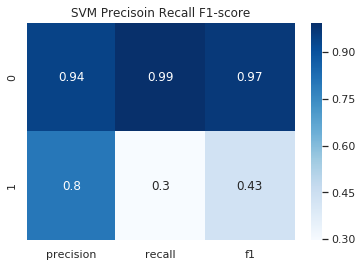

In [0]:
zero_info = [x[0] for x in pre_rec_arr][:-1]
one_info = [x[1] for x in pre_rec_arr][:-1]
import seaborn as sns; sns.set()
arr = np.array([zero_info,one_info])
#arr
ax = sns.heatmap(arr,annot=True,xticklabels=["precision","recall","f1"],cmap="Blues")
ax.set_title("SVM Precisoin Recall F1-score")

## XGboost

In [0]:
num_pos = (test==1).sum()
num_neg = (test==0).sum()
#gb = XGBClassifier(scale_pos_weight=num_neg/num_pos)#GradientBoostingClassifier(n_estimators=700, max_depth=5)
gb = XGBClassifier(n_estimators = 500, scale_pos_weight = num_neg/num_pos, max_depth = 5,eval_metric = ['auc'])
#gb = XGBClassifier()
gb.fit(X, test)
y_pred = gb.predict(X_pri)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_pri, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#2hours to run

Accuracy: 88.62%


Add feature weights<br>
0.18675346035543405 avg_precision_recall
0.18646408839779008 f1_scaore
0.10416666666666667 recall
0.8881578947368421 precision<br>
Train and test on the private data.<br>
Before balance,
<br>Acc: 90.44%<br>
True:152<br>
False:12168<br>
Precision: <br>
Recall: <br>
F1-score: <br>
Avg Precision Recall:<br>
Very low performance. Even though it has high accuracy
After balance,<br>
0.2603518763758695 avg_precision_recall
0.45418080839247144 f1_scaore
0.5679012345679012 recall
0.37840616966580976 precision
<br>Acc: 85.64%<br>
True:3265<br>
False:9055<br>
Precision: <br>
Recall: <br>
F1-score: <br>
Avg Precision Recall: <br>
Precision is very low, so a lot of true label are actually false! Very high false positive rate.

In [0]:
#Save the model
import pickle
filename = 'XGBoost_balanced.sav'
pickle.dump(gb, open(filename, 'wb'))

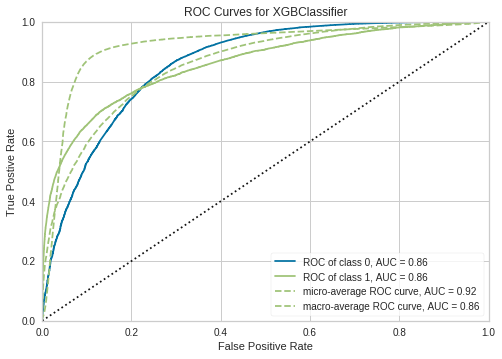

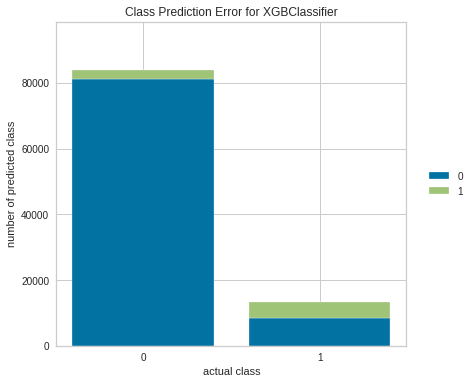

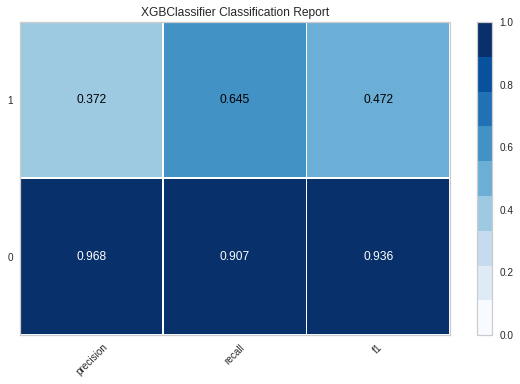

In [0]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
rocauc = ROCAUC(gb, classes=[0,1])

rocauc.score(X_pri, test_pri)  
r = rocauc.poof()
error = ClassPredictionError(gb, classes=[0,1])

error.score(X_pri, test_pri)
e = error.poof()
report = ClassificationReport(gb, classes=[0,1],cmap = "Blues")

report.score(X_pri, test_pri)
c = report.poof()

Text(0.5, 1, 'XGBoost Precisoin Recall F1-score')

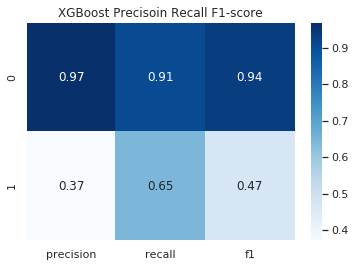

In [0]:
from sklearn.metrics import precision_recall_fscore_support
pre_rec_arr = precision_recall_fscore_support(test_pri,y_pred,labels = [0,1])
zero_info = [x[0] for x in pre_rec_arr][:-1]
one_info = [x[1] for x in pre_rec_arr][:-1]
import seaborn as sns; sns.set()
arr = np.array([zero_info,one_info])
#arr
ax = sns.heatmap(arr,annot=True,xticklabels=["precision","recall","f1"],cmap="Blues")
ax.set_title("XGBoost Precisoin Recall F1-score")

Train and test on the public data.<br>
Before balance,
<br>Acc: 90.26%<br>
True:674<br>
False:463744<br>
Precision: 0.856<br>
Recall: 0.114<br>
F1-score: 0.201<br>
Avg Precision Recall: 0.193<br>
High precision but low recall. So the true prediction is very pure miss a lot of true labels too. 
After balance,<br>
Acc: 85.13%<br>
True: 7797<br>
False: 339221<br>
Precision: 0.376<br>
Recall: 0.580<br>
F1-score: 0.456<br>
Avg Precision Recall: 0.263<br>
Precision is very low, so a lot of true label are actually false! Very high false positive rate.

In [0]:
#ensemble with LSTM
xgb_proba = gb.predict_proba(X_pri)

In [0]:
print(sum(xgb_proba[:,1]>0.5))#predict 1
print(sum(xgb_proba[:,1] < 0.5))#predict 0

13303
84017


In [0]:
print(sum(lstm_pred['prediction'] < 0.5))#predict 0
print(sum(lstm_pred['prediction'] > 0.5)) #predict 1

88233
9087


In [0]:
sum(test_pri > 0.5)

7671

0.0 0.9443485408960132
0.1 0.9442868886148787
0.2 0.9432182490752158
0.30000000000000004 0.9417796958487464
0.4 0.9387792848335389
0.5 0.9334669132757912
0.6000000000000001 0.9263974517057131
0.7000000000000001 0.9181052198931361
0.8 0.9091348129880805
0.9 0.8986333744348541


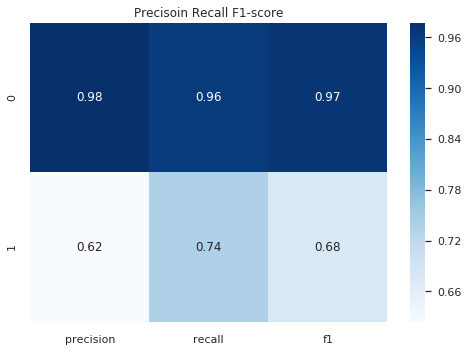

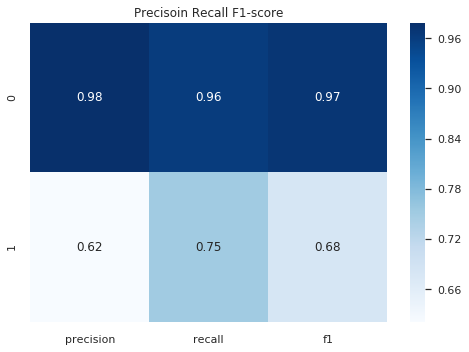

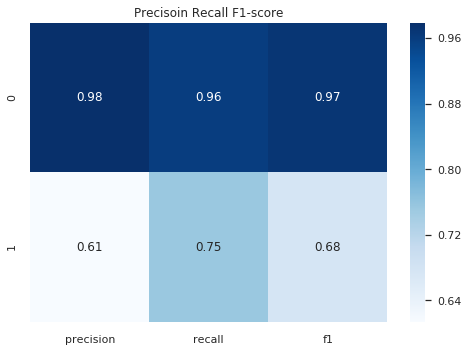

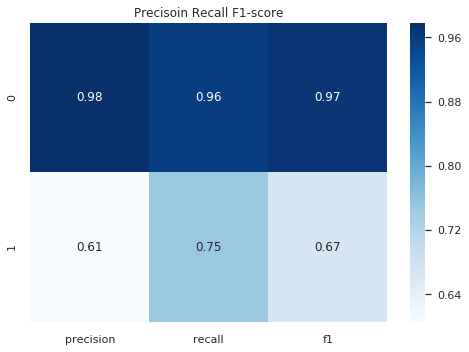

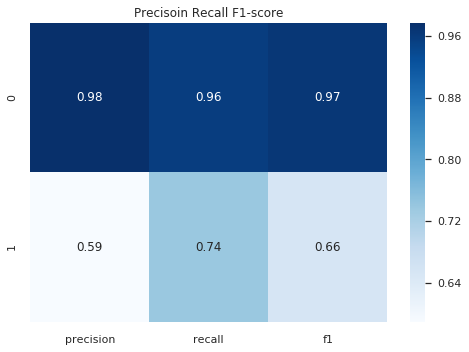

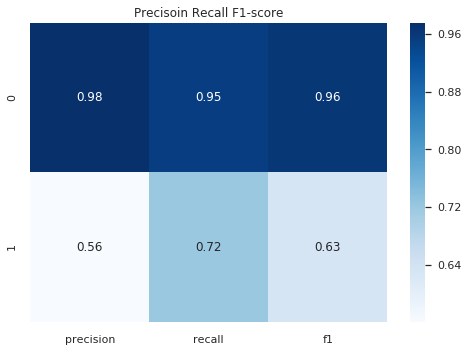

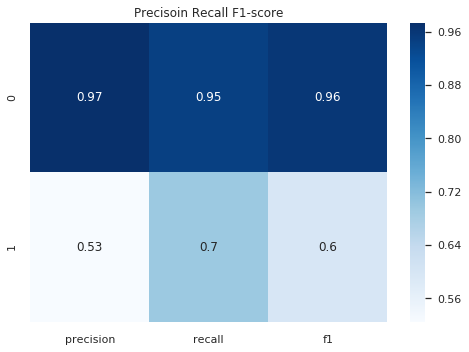

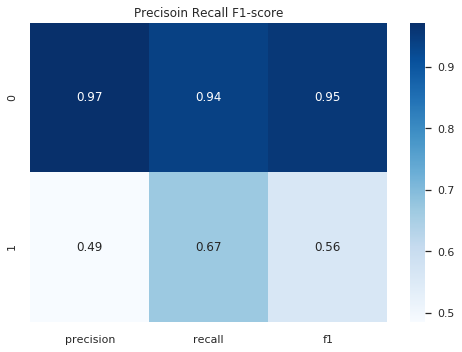

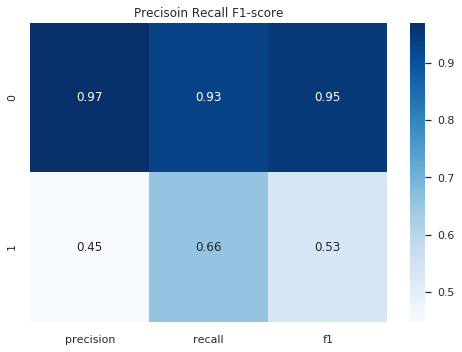

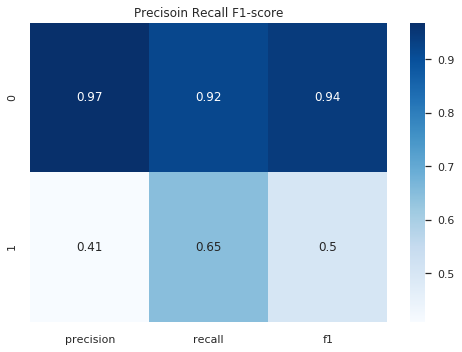

In [0]:
import matplotlib.pyplot as plt
for i in np.arange(0,1,0.1):
  new_proba = xgb_proba[:,1]*i+lstm_pred['prediction']*(1-i)
  predictions_new = np.zeros((len(xgb_proba),1))
  predictions_new[new_proba > 0.5,:] = 1
  accuracy = accuracy_score(test_pri, predictions_new)
  print(i,accuracy)
  pre_rec_arr = precision_recall_fscore_support(test_pri,predictions_new,labels = [0,1])
  zero_info = [x[0] for x in pre_rec_arr][:-1]
  one_info = [x[1] for x in pre_rec_arr][:-1]
  plt.figure() 
  arr = np.array([zero_info,one_info])
#arr
  ax = sns.heatmap(arr,annot=True,xticklabels=["precision","recall","f1"],cmap="Blues")
  ax.set_title("Precisoin Recall F1-score")

In [0]:
num_pos = (test_pri==1).sum()
num_neg = (test_pri==0).sum()
gb = XGBClassifier(scale_pos_weight = num_neg/num_pos)#GradientBoostingClassifier(n_estimators=700, max_depth=5)
gb.fit(X, test)
y_pred = gb.predict(X_pri)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_pri, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Train and test on the private data.<br>
Before balance,
<br>Acc: 90.44%<br>
True:152<br>
False:12168<br>
Precision: 0.888<br>
Recall: 0.104<br>
F1-score: 0.186<br>
Avg Precision Recall: 0.187<br>
High precision but low recall. So the true prediction is very pure miss a lot of true labels too. 
After balance,<br>
Acc: 85.47%<br>
True: 1986<br>
False: 10334<br>
Precision: 0.376<br>
Recall: 0.576<br>
F1-score: 0.455<br>
Avg Precision Recall: 0.261<br>
Precision is very low, so a lot of true label are actually false! Very high false positive rate.

In [0]:
print(sum(np.array(predictions) == 1))
print(sum(np.array(predictions) == 0))

152
12168


In [0]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print(average_precision_score(test_pri, predictions))
print(f1_score(test_pri,predictions))
print(recall_score(test_pri,predictions))
print(precision_score(test_pri,predictions))

0.2603518763758695
0.45418080839247144
0.5679012345679012
0.37840616966580976


In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_pri,predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11024
           1       0.89      0.10      0.19      1296

    accuracy                           0.90     12320
   macro avg       0.90      0.55      0.57     12320
weighted avg       0.90      0.90      0.87     12320



In [0]:
#Train the model on the attributions
train_att = train.loc[:,[col for col in train.columns if col not in ["id","severe_toxicity","obscene","threat","insult","identity_attack","sexual_explicit","comment_text","identity_annotator_count","toxicity_annotator_count","created_date","publication_id","parent_id","article_id","rating"]]]
test_att = train_pri.loc[:,[col for col in train.columns if col not in ["id","severe_toxicity","obscene","threat","insult","identity_attack","sexual_explicit","comment_text","identity_annotator_count","toxicity_annotator_count","created_date","publication_id","parent_id","article_id","rating"]]]

In [0]:
train_att.head()

,id,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,funny,wow,sad,likes,disagree
11,239579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
31,239607,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
51,239644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
58,239653,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0,0,0,2,0
111,239744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0


In [0]:
num_pos = (test_pri==1).sum()
num_neg = (test_pri==0).sum()
gb = XGBClassifier()#GradientBoostingClassifier(n_estimators=700, max_depth=5)
gb.fit(train_att, test)
y_pred = gb.predict(test_att)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_pri, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.50%


Train and test on the private data.<br>
Before balance,
<br>Acc: 89.50%<br>
True:23<br>
False:12297<br>
Precision: 0.565<br>
Recall: 0.01<br>
F1-score: 0.02<br>
Avg Precision Recall: 0.110<br>
Very low performance. Even though it has high accuracy
After balance,
<br>Acc: 74.23%<br>
True:3265<br>
False:9055<br>
Precision: 0.212<br>
Recall: 0.535<br>
F1-score: 0.304<br>
Avg Precision Recall: 0.162<br>
Precision is very low, so a lot of true label are actually false! Very high false positive rate.

In [0]:
#Try to balance the data and do the nlp again!


In [0]:
le = LabelEncoder() 
#np.set_printoptions(threshold=100)

# df = pd.read_csv("../MIDAS/project_profit.csv", encoding = "ISO-8859-1")
#df = pd.read_csv("project_profit.csv", encoding = "ISO-8859-1")
#This time we dont need to drop nan cuz xgboost will handle it!
num_pos = (y_train==1).sum()
num_neg = (y_train==0).sum()
gb = XGBClassifier()#GradientBoostingClassifier(n_estimators=700, max_depth=5)
#df = df.replace([np.inf, -np.inf], sys.maxsize)

catagory_idx = []
i = 0
for (col_name, col) in df.iteritems():
  if col.dtype == 'object':
    df[col_name] = le.fit_transform(df[col_name])
    catagory_idx.append(i)
  i += 1

onehotencoder = OneHotEncoder(categorical_features = catagory_idx)
# df = df.dropna(axis=0)
# response = df['profit']
# df = df.drop(columns=['profit'])#, 'profit_per', 'total profit', 'FamilyRevenueMTD', 'FamilyOverheadMTD', 'FamilyCostMTD', 'CostMTD', 'OverheadMTD'])
# features = list(df.columns)

idx = np.random.permutation(response.shape[0])
#print((df == np.nan).sum())
rand_pred = df#np.array(df)
rand_resp = np.array(response)[idx]
rand_pred = rand_pred.iloc[idx]

gb.fit(train_att, test)
y_pred = gb.predict(test_att)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_pri, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [0]:
#!pip install shap
import shap

In [0]:
shap_values = shap.TreeExplainer(gb).shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar')
shap.summary_plot(shap_values, X)

,target,comment_text
11,0.4400,This is a great story. Man. I wonder if the pe...
31,0.9125,Yet call out all Muslims for the acts of a few...
51,0.0000,Because the people who drive cars more are the...
58,0.3000,Mormons have had a complicated relationship wi...
111,0.0000,I'm doing the same thing! :)
...,...,...
1804852,0.3000,Xi and his comrades must be smirking over Trum...
1804858,0.2000,My thought exactly. The only people he hasn't...
1804861,0.0000,"I agree, Bill G\nThe vote-buying has begun by ..."
1804862,0.0000,"No, the probability of dying may be very, very..."


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X,test)
y_pred = rf.predict(X_pri)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_pri, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 89.94%


Text(0.5, 1, 'RandomForest Precisoin Recall F1-score')

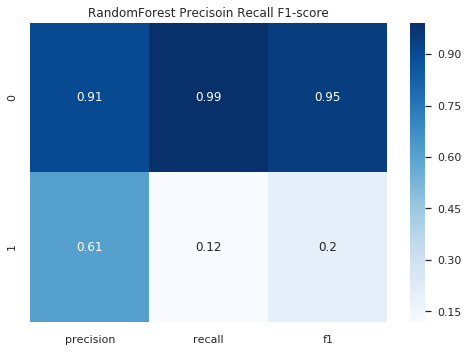

In [0]:
from sklearn.metrics import precision_recall_fscore_support
pre_rec_arr = precision_recall_fscore_support(test_pri,y_pred,labels = [0,1])
zero_info = [x[0] for x in pre_rec_arr][:-1]
one_info = [x[1] for x in pre_rec_arr][:-1]
import seaborn as sns; sns.set()
arr = np.array([zero_info,one_info])
#arr
ax = sns.heatmap(arr,annot=True,xticklabels=["precision","recall","f1"],cmap="Blues")
ax.set_title("RandomForest Precisoin Recall F1-score")

#Try XGboosT UI

In [0]:
import pickle
model_name = './XGBoost_balanced.sav'
fp = open(model_name,"rb")
model_xgboost = pickle.load(fp)
print("loading tokenizer")
tokenizer = pickle.load(open('./vector_sentence.bin','rb'))

loading tokenizer


In [0]:
def inference_xgboost(input_text, model_xgboost, tokenizer):
  print("Predicting")
  X_test = tokenizer.transform(input_text)
  pred = model_xgboost.predict_proba(X_test)
  print("non-toxic",pred[0][0])
  print("toxic",pred[0][1])


In [0]:
def inference_SVM(input_text, model_SVM, tokenizer):
  print("Predicting")
  X_test = tokenizer.transform(input_text)
  pred = model_SVM.predict_proba(X_test)
  print("non-toxic",pred[0][0])
  print("toxic",pred[0][1])

In [0]:
inference_xgboost(['This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.62779164
toxic 0.37220833


In [0]:
inference_xgboost(['Nah, I am too boring to parody.  This guy Campbe, II, is a magician--he chose you and indubitably snarky.  A lot of bang for the buck there! :D'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.5840103
toxic 0.4159897


In [0]:
inference_xgboost(['haha you guys a bunch of losers'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.58234906
toxic 0.41765097


In [0]:
inference_xgboost(["Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?"],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.21547359
toxic 0.7845264


In [0]:
inference_xgboost(['Because the people who drive cars more are the ones who cause more wear and tear on the roads?  Pretty fair and straightforward.'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.60715044
toxic 0.39284956


In [0]:
inference_xgboost(['At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.6145083
toxic 0.3854917


In [0]:
inference_xgboost(['male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino'],model_xgboost=model_xgboost,tokenizer=tokenizer)

Predicting
non-toxic 0.17139655
toxic 0.82860345


In [0]:
model_xgboost.predict_proba(tokenizer.transform(["good","bad"]))

array([[0.5899681 , 0.41003194],
       [0.5899681 , 0.41003194]], dtype=float32)

In [0]:
a = df.loc[:,["target","comment_text"]]

In [0]:
a.loc[a['target']>0.5,:].iloc[0,1]

"Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?"

In [0]:
a.loc[a['target']<0.5,:].iloc[1,1]

'Because the people who drive cars more are the ones who cause more wear and tear on the roads?  Pretty fair and straightforward.'

In [0]:
model_xgboost.predict_proba(tokenizer.transform(["Because the people who drive cars more are the ones who cause more wear and tear on the roads?  Pretty fair and straightforward.","Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?"]))

array([[0.60715044, 0.39284956],
       [0.21547359, 0.7845264 ]], dtype=float32)

In [0]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 52kB/s 
     |████████████████████████████████| 204kB 43.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=01f00d3a934dcd429328091f158944bcdcd555abc70c46b845459f84b4234783
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

## Cross-validation and downsampling